In [ ]:
# import necassary files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import random
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler 
from sklearn.decomposition import PCA

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Read datasets to pandas Dataframe

In [ ]:
# aisles dataset
aisles = pd.read_csv('/content/gdrive/MyDrive/aisles.csv')

In [ ]:
# orders, orders prior, orders train
orders = pd.read_csv('/content/gdrive/MyDrive/orders.csv')
order_products_train = pd.read_csv('/content/gdrive/MyDrive/order_products__train.csv')
order_products_prior = pd.read_csv('/content/gdrive/MyDrive/order_products__prior.csv')

In [ ]:
# product dataset
products = pd.read_csv('/content/gdrive/MyDrive/products.csv')

In [ ]:
# department dataset
departments = pd.read_csv('/content/gdrive/MyDrive/departments.csv')

In [ ]:
# Merged file
final_file = pd.read_csv('/content/gdrive/MyDrive/merged_file1.csv')
final_file['days_since_prior_order']=final_file['days_since_prior_order'].fillna(-999)

## **Random sample the user ids for building model**
- Choosing only 5000 user ids who have purchased more than 50 unique products, as there are more than 2 lakhs users approx.

In [ ]:
final_file.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,product_name,aisle_id,department_id
0,2539329,1,1,2,8,-999.0,196,1,Soda,77,7
1,2539329,1,1,2,8,-999.0,14084,2,Organic Unsweetened Vanilla Almond Milk,91,16
2,2539329,1,1,2,8,-999.0,26088,4,Aged White Cheddar Popcorn,23,19
3,2539329,1,1,2,8,-999.0,12427,3,Original Beef Jerky,23,19
4,2539329,1,1,2,8,-999.0,26405,5,XL Pick-A-Size Paper Towel Rolls,54,17


In [ ]:
print('Average number of products per order is',round(final_file.groupby(['user_id','order_id'])['product_id'].count().mean()))

Average number of products per order is 10


In [ ]:
users_bought_n_prods = final_file.groupby('user_id')['product_id'].nunique().sort_values()
users_bought_n_prods

user_id
20956       1
92835       1
29153       1
11414       1
33887       1
         ... 
31310     611
152144    616
151994    643
75304     689
182401    726
Name: product_id, Length: 206209, dtype: int64

In [ ]:
users_bought_n_prods.loc[lambda x:x>=50]

user_id
159114     50
92249      50
91581      50
181890     50
158986     50
         ... 
31310     611
152144    616
151994    643
75304     689
182401    726
Name: product_id, Length: 99348, dtype: int64

In [ ]:
users_bought_50_plus_prods = users_bought_n_prods.loc[lambda x:x>=50].index
users_bought_50_plus_prods

Int64Index([159114,  92249,  91581, 181890, 158986,  88752,  89024,  91587,
             91734,  92292,
            ...
            106161, 181209, 185080, 143961, 116571,  31310, 152144, 151994,
             75304, 182401],
           dtype='int64', name='user_id', length=99348)

In [ ]:
random.seed(100)
users_5000 = random.sample(list(users_bought_50_plus_prods), 5000)
del users_bought_50_plus_prods
len(users_5000)

5000

## **Data Preparation**

In [ ]:
# final file is the merge of prior and dept and aisles
new_data = final_file[final_file.user_id.isin(users_5000)]

In [ ]:
new_data.product_id.nunique()

33445

In [ ]:
new_data.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,product_name,aisle_id,department_id
23092,773377,169,1,4,16,-999.0,13176,11,Bag of Organic Bananas,24,4
23093,773377,169,1,4,16,-999.0,36011,10,Organic Fat Free Milk,84,16
23094,773377,169,1,4,16,-999.0,28204,5,Organic Fuji Apple,24,4
23095,773377,169,1,4,16,-999.0,24954,12,Total 0% with Honey Nonfat Greek Strained Yogurt,120,16
23096,773377,169,1,4,16,-999.0,30489,1,Original Hummus,67,20


## **Feature Engineering - To cluster users based on purchase behaviour**

In [ ]:
data1 = round(new_data.groupby('user_id')[['order_dow','order_hour_of_day']].mean())
data1['number_of_orders'] = new_data.groupby('user_id')['order_id'].nunique()
data1['max_days_since_prior_order'] = new_data.groupby('user_id')['days_since_prior_order'].max()
data1['min_days_since_prior_order'] = new_data[new_data['days_since_prior_order'] > 0].groupby('user_id')['days_since_prior_order'].min()
data1['avg_days_since_prior_order'] = round(new_data[new_data['days_since_prior_order'] > 0].groupby('user_id')['days_since_prior_order'].mean())
data1['unique_products'] = new_data.groupby('user_id')['product_id'].nunique()
data1['most_bought_product'] = new_data.groupby('user_id')['product_id'].value_counts().groupby('user_id').nlargest(1).droplevel(level=0).reset_index(level=1,name='values').drop('values',1)
data1['most_bought_dept'] = new_data.groupby('user_id')['department_id'].value_counts().groupby('user_id').nlargest(1).droplevel(level=0).reset_index(level=1,name='values').drop('values',1)
data1['most_bought_aisle'] = new_data.groupby('user_id')['aisle_id'].value_counts().groupby('user_id').nlargest(1).droplevel(level=0).reset_index(level=1,name='values').drop('values',1)
data1['avg_no_products_per_order'] = round(final_file.groupby(['user_id','order_id'])['product_id'].nunique().groupby('user_id').mean())
data1

,order_dow,order_hour_of_day,number_of_orders,max_days_since_prior_order,min_days_since_prior_order,avg_days_since_prior_order,unique_products,most_bought_product,most_bought_dept,most_bought_aisle,avg_no_products_per_order
user_id,,,,,,,,,,,
169,3.0,15.0,6,30.0,6.0,24.0,76,47766,16,24,14.0
216,4.0,15.0,17,24.0,5.0,13.0,89,27086,16,24,20.0
279,2.0,14.0,14,30.0,6.0,18.0,77,45,4,107,7.0
352,2.0,13.0,10,30.0,8.0,22.0,115,11100,4,24,20.0
369,3.0,17.0,16,30.0,1.0,19.0,56,4920,4,32,8.0
...,...,...,...,...,...,...,...,...,...,...,...
205980,4.0,14.0,41,24.0,3.0,9.0,92,2408,16,21,7.0
205989,2.0,11.0,12,30.0,4.0,21.0,95,27313,19,3,16.0
206000,2.0,16.0,14,22.0,1.0,6.0,101,40691,4,83,14.0


In [ ]:
data1.describe()

,order_dow,order_hour_of_day,number_of_orders,max_days_since_prior_order,min_days_since_prior_order,avg_days_since_prior_order,unique_products,most_bought_product,most_bought_dept,most_bought_aisle,avg_no_products_per_order
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,2.727000,13.553800,23.862800,26.537800,4.049200,13.178600,106.976200,22815.968400,6.932000,65.543200,13.05920
std,0.932011,1.924018,19.341613,6.177233,4.369599,6.098274,56.555026,13539.272908,5.383342,34.982368,5.91394
min,0.000000,5.000000,3.000000,2.000000,1.000000,2.000000,50.000000,4.000000,1.000000,1.000000,2.00000
25%,2.000000,12.000000,10.000000,25.000000,1.000000,8.000000,66.000000,12318.750000,4.000000,24.000000,9.00000
50%,3.000000,14.000000,17.000000,30.000000,3.000000,12.000000,89.000000,23234.500000,4.000000,83.000000,12.00000
75%,3.000000,15.000000,32.000000,30.000000,5.000000,17.000000,132.000000,32141.000000,7.000000,83.000000,16.00000
max,6.000000,21.000000,99.000000,30.000000,30.000000,30.000000,608.000000,49683.000000,21.000000,134.000000,53.00000


## **Clustering users using KMeans**
### K-Means Assumptions
- Variables has to be normally distributed and hence, we transform the data using Log Transformation.

- All variables must be in the same scale. So, using MinMaxScaler which does not change the shape of the distribution, it just shrinks the values to a specified range (0,1). Thus, the nature of information dataset contains remains unaltered.

- Then, apply K-Means clustering on the transformed features.

In [ ]:
scaler = MinMaxScaler()
data1_log = np.log(data1+1)
data1_Cluster_Tran = pd.DataFrame(scaler.fit_transform(data1_log),columns=data1.columns,index=data1.index) 
round(data1_Cluster_Tran.describe(),2)

,order_dow,order_hour_of_day,number_of_orders,max_days_since_prior_order,min_days_since_prior_order,avg_days_since_prior_order,unique_products,most_bought_product,most_bought_dept,most_bought_aisle,avg_no_products_per_order
count,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00
mean,0.66,0.68,0.49,0.93,0.25,0.62,0.26,0.88,0.50,0.79,0.51
std,0.14,0.10,0.23,0.13,0.24,0.19,0.18,0.11,0.24,0.16,0.14
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.56,0.60,0.31,0.92,0.00,0.47,0.11,0.85,0.38,0.60,0.42
50%,0.71,0.71,0.47,1.00,0.25,0.63,0.23,0.92,0.38,0.89,0.51
75%,0.71,0.75,0.66,1.00,0.40,0.77,0.39,0.95,0.58,0.89,0.60
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


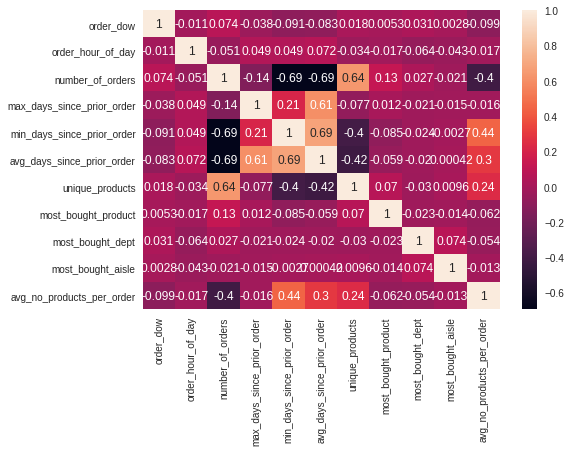

In [ ]:
sns.heatmap(data1_Cluster_Tran.corr(),annot=True);

## **Determine the optimal number of clusters** 
#### **Elbow curve**

In [ ]:
cl = range(1,11)
wcsse = []
for i in cl:
    mod = KMeans(n_clusters=i,random_state=0,n_init=30) 
    mod.fit(data1_Cluster_Tran)
    print(mod.inertia_)
    wcsse.append(mod.inertia_)

1714.1246967400716
1264.662654211597
1102.8724684796348
996.4962598193349
921.1020807051772
868.5444430255611
827.0197448644503
793.0657968026729
763.9589540372407
737.6408973846706


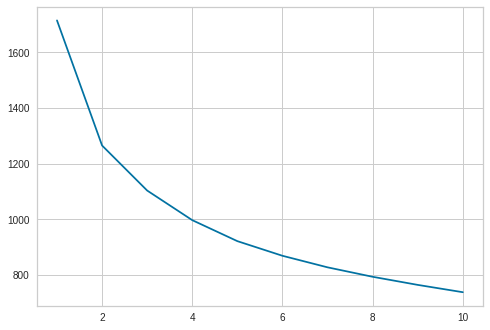

In [ ]:
plt.plot(cl,wcsse) # ELBOW Curve

#### **Observations**
- At k = 2/3, there are inflection/elbow points. 
- To confirm the optimal k value, we check for silhoutte score.

#### **Silhouette score**

In [ ]:
cl = range(2,11)  
sil1 = []
for i in cl:
    mod = KMeans(n_clusters=i,random_state=0,n_init=30) 
    mod.fit(data1_Cluster_Tran)
    sil1.append(silhouette_score(data1_Cluster_Tran,mod.labels_))

In [ ]:
sil1

[0.2267114620151785,
 0.21871169193067316,
 0.16626172695834784,
 0.17037103584456592,
 0.17602211976860788,
 0.14780323600603446,
 0.14399316794744912,
 0.14021557176547314,
 0.1422784019750888]

#### **Observations**

- For k=2, the score is high - so k=2 cluster's performance is good.
- So, choosing optimal cluster value as 2.

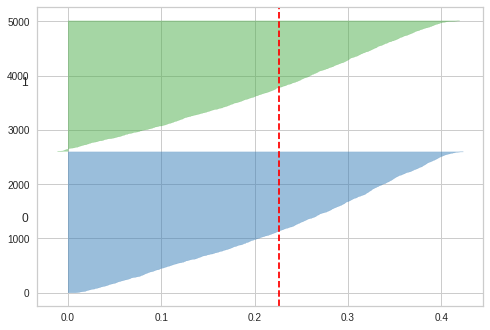

In [ ]:
model = KMeans(n_clusters=2, random_state=0,n_init=30)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(data1_Cluster_Tran)        
plt.show()

#### **Observations**

- All the cluster crosses the avg silhouette score line - which is a good indicator.
- Should have rectangular band - Both the clusters doesn't have much of a rectangular shape.
- cluster1 has negative silhoute scores for very few data points - This indicates that distance between two clusters is not big.

In [ ]:
kmeans = KMeans(n_clusters=2,random_state=0,n_init=30)
kmeans = kmeans.fit(data1_Cluster_Tran)
labels = kmeans.predict(data1_Cluster_Tran)
centroids = kmeans.cluster_centers_
print("Centroid values")
print(centroids)  

Centroid values
[[0.67001688 0.66951696 0.64903474 0.9045158  0.07940596 0.49489608
  0.34531236 0.89193817 0.50523221 0.78907596 0.45955152]
 [0.64458309 0.68098617 0.30803219 0.96408647 0.43349194 0.76210449
  0.16439853 0.87246594 0.48854702 0.78425777 0.55594602]]


In [ ]:
data1_labels = data1.copy()
data1_labels['Group'] = labels

In [ ]:
data1_labels.head()

,order_dow,order_hour_of_day,number_of_orders,max_days_since_prior_order,min_days_since_prior_order,avg_days_since_prior_order,unique_products,most_bought_product,most_bought_dept,most_bought_aisle,avg_no_products_per_order,Group
user_id,,,,,,,,,,,,
169,3.0,15.0,6,30.0,6.0,24.0,76,47766,16,24,14.0,1
216,4.0,15.0,17,24.0,5.0,13.0,89,27086,16,24,20.0,1
279,2.0,14.0,14,30.0,6.0,18.0,77,45,4,107,7.0,1
352,2.0,13.0,10,30.0,8.0,22.0,115,11100,4,24,20.0,1
369,3.0,17.0,16,30.0,1.0,19.0,56,4920,4,32,8.0,1


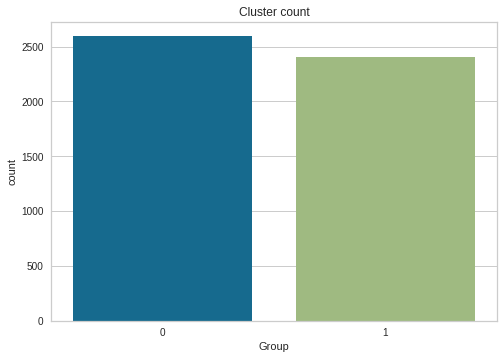

In [ ]:
plt.title('Cluster count')
sns.countplot(x=data1_labels.Group);

In [ ]:
data1_labels.Group.value_counts()

0    2596
1    2404
Name: Group, dtype: int64

#### **Observations**
- There are 2596 users in cluster 0 and 2404 users in cluster 1.
- A good cluster analysis has all clusters with population between 5-30% of the overall base. Here, both the clusters has more than 30% of the overall datapoints(more than 1500). So, this qualifies as a good cluster analysis.

## **Applying PCA on the data - To reduce dimensions**

In [ ]:
pca = PCA(n_components = data1_Cluster_Tran.shape[1],random_state=0)
pca_data = pca.fit_transform(data1_Cluster_Tran)
exp_var_ratio= pca.explained_variance_ratio_

cum_var=exp_var_ratio[0]
itr=2 # defined as two as first pc1 variance defined outside the loop
for j in exp_var_ratio[1:]:
    cum_var=cum_var+j
    if cum_var >= 0.90:
        break
    itr=itr+1

print('The number of principle components capturing 90 percent varaition is data is : ',itr,' Varaince explained is ', cum_var)

The number of principle components capturing 90 percent varaition is data is :  7  Varaince explained is  0.9128298015822088


Text(0, 0.5, 'Variance Ratio')

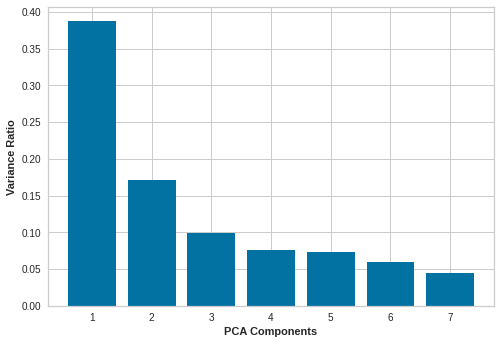

In [ ]:
# Variance Ratio bar plot for each PCA components.
pc=exp_var_ratio[:itr]
ax = plt.bar(range(1,len(pc)+1), pc)
plt.xlabel("PCA Components",fontweight = 'bold')
plt.ylabel("Variance Ratio",fontweight = 'bold')

In [ ]:
#Select only 7 PCs
pcadata=pca_data[:,:itr]
pcadata.shape

(5000, 7)

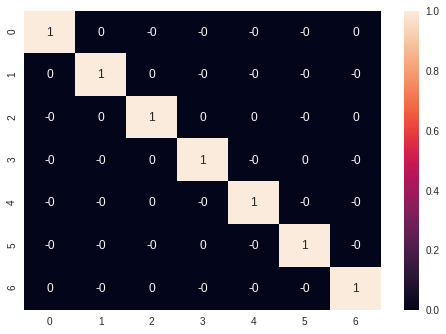

In [ ]:
sns.heatmap(pd.DataFrame(pcadata).corr().round(),annot=True);

Text(0, 0.5, 'Cumulative Explained Variance')

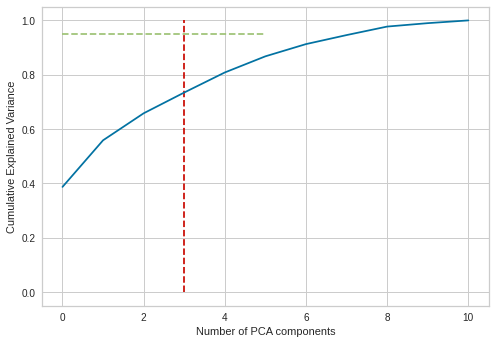

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.vlines(x=3, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=5, xmin=0, colors="g", linestyles="--")
plt.xlabel('Number of PCA components')
plt.ylabel('Cumulative Explained Variance')

In [ ]:
# Checking which attributes are well explained by the pca components
attributes_pca=pd.DataFrame()
for i in range(7):
    attributes_pca['PC'+str(i+1)]=pca.components_[i]
attributes_pca['Attribute']=data1_Cluster_Tran.columns
attributes_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,Attribute
0,-0.042793,-0.028689,-0.113077,0.006971,-0.017207,-0.991089,0.036950,order_dow
1,0.019299,0.033049,-0.016545,0.055820,-0.024714,0.007070,-0.018393,order_hour_of_day
2,-0.568277,0.018310,0.177763,0.178785,-0.239572,-0.001761,-0.519415,number_of_orders
3,0.119930,0.009706,0.084245,0.350393,-0.617044,0.004559,0.091322,max_days_since_prior_order
4,0.575436,0.001292,0.318579,-0.045497,0.150093,-0.092654,-0.714732,min_days_since_prior_order
5,0.455648,-0.006593,0.099731,0.255318,-0.465374,-0.015458,0.179844,avg_days_since_prior_order
6,-0.308619,0.083042,0.728538,0.015429,-0.068820,-0.078899,0.123237,unique_products
7,-0.033709,0.015723,0.007522,0.047283,-0.061279,0.006301,-0.115595,most_bought_product
8,-0.027670,-0.989797,0.096255,0.078279,0.044164,0.019649,0.020892,most_bought_dept
9,0.001203,-0.088432,0.016201,-0.864242,-0.490296,0.002495,-0.044257,most_bought_aisle


In [ ]:
col=list(np.arange(1,pcadata.shape[1]+1))
col

[1, 2, 3, 4, 5, 6, 7]

In [ ]:
# Creating new dataframe with Principal components

df_pca_final = pd.DataFrame(pcadata, columns=col)
#df_pca_final = pd.concat([data['country'], df_pca], axis=1)
df_pca_final.head()

,1,2,3,4,5,6,7
0,0.454428,-0.383384,0.033682,0.225336,0.051313,-0.063432,0.082788
1,0.127160,-0.370056,0.131183,0.167362,0.173453,-0.179767,-0.018880
2,0.275971,0.075510,-0.082206,-0.111687,-0.151892,0.079983,-0.087155
3,0.402194,0.143082,0.236158,0.169306,0.059963,0.044664,0.006839
4,0.025217,0.100467,-0.308452,0.190185,-0.119582,-0.013036,0.179923


1564.704106812405
1115.2671213323922
953.4898430305427
847.3199028625779
771.9082770484391
719.7710698570384
678.3627323535954
644.6582694406266
615.6725248387536
589.5131285507748
568.7362497623315
550.647440176069


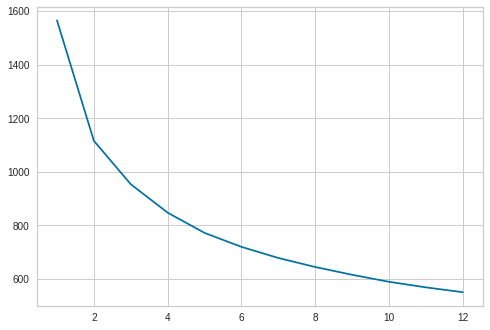

In [ ]:
# K-means Clustering
wcss=[]
cl=[1,2,3,4,5,6,7,8,9,10,11,12]
for k in cl:
    mod=KMeans(n_clusters=k, random_state= 0, n_init=30)
    mod.fit(pcadata)
    print(mod.inertia_)
    wcss.append(mod.inertia_)
plt.plot(cl,wcss)

In [ ]:
# compute Silhoutee score
from sklearn.metrics import silhouette_score
sil=[]
cl=[2,3,4,5,6,7,8]
for k in cl:
    mod=KMeans(n_clusters=k, random_state= 0, n_init=30)
    mod.fit(pcadata)
    score=silhouette_score(pcadata,mod.labels_)
    print(score)
    sil.append(score)

0.2485857117670079
0.24432220232219523
0.1904406310284726
0.19710389448461388
0.20417579620992232
0.17558214382336426
0.17240018666879242


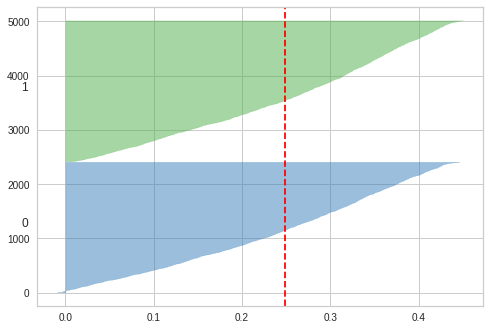

In [ ]:
model = KMeans(n_clusters=2, random_state=0,n_init=30)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(pcadata)        
plt.show()

In [ ]:
cluster1 = KMeans(n_clusters=2, random_state= 0, n_init=30)
cluster1.fit(pcadata)
# Assign the label
data2_labels = data1.copy()
data2_labels['Group'] = cluster1.labels_
data2_labels.head()

,order_dow,order_hour_of_day,number_of_orders,max_days_since_prior_order,min_days_since_prior_order,avg_days_since_prior_order,unique_products,most_bought_product,most_bought_dept,most_bought_aisle,avg_no_products_per_order,Group
user_id,,,,,,,,,,,,
169,3.0,15.0,6,30.0,6.0,24.0,76,47766,16,24,14.0,0
216,4.0,15.0,17,24.0,5.0,13.0,89,27086,16,24,20.0,0
279,2.0,14.0,14,30.0,6.0,18.0,77,45,4,107,7.0,0
352,2.0,13.0,10,30.0,8.0,22.0,115,11100,4,24,20.0,0
369,3.0,17.0,16,30.0,1.0,19.0,56,4920,4,32,8.0,0


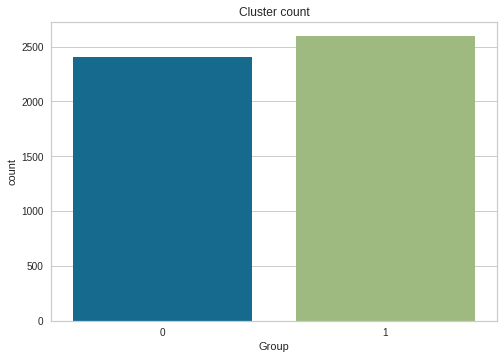

In [ ]:
plt.title('Cluster count')
sns.countplot(x=data2_labels.Group);

In [ ]:
data2_labels.Group.value_counts()

1    2596
0    2404
Name: Group, dtype: int64

#### **Observations**
- Its observed that clustering using PCA results in same number of users in each cluster yet, the silhouette score has increased a little and hence using the PCA clusters for further analysis.

# Transform product_id to string and compute tf-idf in it

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
token_pattern_ = r'([a-zA-Z0-9-/]{1,})'

In [ ]:
new_data1 = new_data[['user_id','product_id']]

In [ ]:
new_data1['product_id'] = new_data1['product_id'].astype(str)

In [ ]:
data3 = new_data1.groupby('user_id')['product_id'].apply(lambda x: ','.join(x)).reset_index(name='product_list')
del new_data1
data3.head()

,user_id,product_list
0,169,"13176,36011,28204,24954,30489,39877,31640,4183..."
1,216,"47766,3800,24184,23233,44987,30169,29252,42117..."
2,279,"47209,34969,45,45,46049,34957,6722,8695,25843,..."
3,352,"27966,21137,46175,24489,1158,20600,17948,5449,..."
4,369,"23423,4920,21288,7751,8571,4920,13966,43867,43..."


In [ ]:
tf = TfidfVectorizer(token_pattern = token_pattern_)
tf_idf1 = tf.fit_transform(data3['product_list'])
tf_idf1 = pd.DataFrame(tf_idf1.todense(), columns=tf.get_feature_names(), index = data3.user_id)

In [ ]:
tf_idf1.head()

,1,10,100,1000,10001,10004,10005,10006,10008,10009,1001,10010,10011,10014,10015,10016,10017,10022,10023,10025,10027,10029,1003,10031,10032,10033,10034,10035,10036,10037,10038,10039,1004,10040,10041,10043,10044,10047,10048,10049,...,9942,9943,9945,9947,9948,995,9952,9953,9955,9957,996,9961,9963,9964,9966,9967,9968,9969,997,9970,9972,9973,9974,9976,9979,9980,9981,9983,9984,9985,9986,9987,9988,9989,999,9990,9993,9995,9996,9997
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
169,0.0,0.0,0.0,0.0,0.0,0.0,0.132575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
216,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
279,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
352,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
369,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Split the clustered labels into two groups
tf_idf1['Label'] = data2_labels.Group
latent_matrix1 = tf_idf1[tf_idf1.Label == 0]
latent_matrix2 = tf_idf1[tf_idf1.Label == 1]

In [ ]:
latent_matrix1 = latent_matrix1.drop('Label',1)
latent_matrix2 = latent_matrix2.drop('Label',1)
latent_matrix1.shape, latent_matrix2.shape

((2404, 33445), (2596, 33445))

In [ ]:
latent_matrix1.head()

,1,10,100,1000,10001,10004,10005,10006,10008,10009,1001,10010,10011,10014,10015,10016,10017,10022,10023,10025,10027,10029,1003,10031,10032,10033,10034,10035,10036,10037,10038,10039,1004,10040,10041,10043,10044,10047,10048,10049,...,9942,9943,9945,9947,9948,995,9952,9953,9955,9957,996,9961,9963,9964,9966,9967,9968,9969,997,9970,9972,9973,9974,9976,9979,9980,9981,9983,9984,9985,9986,9987,9988,9989,999,9990,9993,9995,9996,9997
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
169,0.0,0.0,0.0,0.0,0.0,0.0,0.132575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
216,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
279,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
352,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
369,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
latent_matrix2.head()

,1,10,100,1000,10001,10004,10005,10006,10008,10009,1001,10010,10011,10014,10015,10016,10017,10022,10023,10025,10027,10029,1003,10031,10032,10033,10034,10035,10036,10037,10038,10039,1004,10040,10041,10043,10044,10047,10048,10049,...,9942,9943,9945,9947,9948,995,9952,9953,9955,9957,996,9961,9963,9964,9966,9967,9968,9969,997,9970,9972,9973,9974,9976,9979,9980,9981,9983,9984,9985,9986,9987,9988,9989,999,9990,9993,9995,9996,9997
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
868,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Identify users in the two clusters ( metric used cosine similarity) for users

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
cos_sim_score1 = pd.DataFrame(cosine_similarity(latent_matrix1,latent_matrix1),columns=latent_matrix1.index,index=latent_matrix1.index)
cos_sim_score2 = pd.DataFrame(cosine_similarity(latent_matrix2,latent_matrix2),columns=latent_matrix2.index,index=latent_matrix2.index)

In [ ]:
cos_sim_score1.head()

user_id,169,216,279,352,369,383,471,860,1019,1064,1261,1299,1495,1559,1607,1707,1795,1915,1949,1977,2030,2061,2079,2127,2285,2349,2464,2475,2504,2652,2732,2740,2927,2986,3126,3236,3335,3518,3618,3655,...,203571,203578,203598,203653,203749,203788,203856,203938,203953,203970,203974,204038,204079,204096,204324,204424,204626,204639,204692,204705,204720,204721,204754,204792,204841,204937,204956,204982,205109,205354,205427,205434,205481,205712,205776,205834,205896,205971,205989,206125
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
169,1.000000,0.050736,0.018427,0.013911,0.000599,0.039779,0.001433,0.014160,0.008663,0.008771,0.013990,0.111620,0.000000,0.060387,0.008768,0.000418,0.004938,0.008632,0.067820,0.027897,0.003911,0.004283,0.000568,0.032902,0.029018,0.069182,0.035779,0.044244,0.011823,0.008504,0.040223,0.040264,0.031871,0.016366,0.020948,0.010480,0.014038,0.010477,0.021331,0.063969,...,0.005635,0.007776,0.018713,0.049607,0.032524,0.033539,0.008143,0.011429,0.065933,0.036540,0.027351,0.017586,0.013223,0.039754,0.029089,0.017714,0.049108,0.019781,0.003774,0.003524,0.031382,0.025075,0.001059,0.060429,0.008133,0.014531,0.007493,0.025082,0.002782,0.008586,0.011025,0.024711,0.005598,0.033175,0.043237,0.025929,0.002230,0.031833,0.000760,0.019612
216,0.050736,1.000000,0.023983,0.005393,0.000360,0.023866,0.018439,0.011405,0.019127,0.004825,0.005439,0.015264,0.000000,0.028342,0.006706,0.000000,0.008285,0.015090,0.024108,0.007447,0.012210,0.006085,0.000342,0.020931,0.019727,0.029065,0.009548,0.095118,0.008143,0.009849,0.012819,0.015552,0.001227,0.001895,0.003825,0.007584,0.040548,0.007315,0.008086,0.016616,...,0.108741,0.023489,0.012280,0.011608,0.028438,0.022534,0.013207,0.011104,0.024282,0.015698,0.003347,0.009791,0.012874,0.035622,0.025141,0.000494,0.018996,0.012243,0.001452,0.000904,0.011259,0.010866,0.005115,0.025764,0.001352,0.011771,0.004699,0.012435,0.011409,0.011040,0.003969,0.017620,0.002440,0.024960,0.004523,0.004932,0.001942,0.034595,0.001196,0.003260
279,0.018427,0.023983,1.000000,0.023785,0.001728,0.019480,0.000000,0.003722,0.001669,0.007197,0.041879,0.009921,0.000000,0.028294,0.030268,0.001061,0.000701,0.013448,0.014090,0.016839,0.011200,0.013164,0.007363,0.008671,0.015095,0.033044,0.005995,0.049652,0.006467,0.007496,0.011497,0.043747,0.001893,0.018856,0.011222,0.010053,0.028653,0.019497,0.044706,0.033754,...,0.000000,0.005552,0.058778,0.006206,0.046694,0.029545,0.013533,0.063858,0.069647,0.005753,0.014416,0.002718,0.045952,0.053725,0.008578,0.005123,0.011274,0.025351,0.003458,0.074583,0.030040,0.043507,0.002449,0.026390,0.007912,0.072659,0.005409,0.001413,0.009835,0.075336,0.000000,0.020516,0.005060,0.036860,0.006853,0.021074,0.015419,0.030613,0.011359,0.016063
352,0.013911,0.005393,0.023785,1.000000,0.011152,0.025390,0.000000,0.009044,0.011740,0.026199,0.057808,0.015655,0.002414,0.014145,0.044394,0.002758,0.005587,0.035626,0.007238,0.013888,0.000000,0.006392,0.006257,0.015799,0.024165,0.035293,0.004627,0.030667,0.063449,0.013670,0.035395,0.054798,0.007887,0.000000,0.025898,0.012517,0.006084,0.023416,0.035470,0.075366,...,0.007612,0.043008,0.046357,0.016087,0.027834,0.053523,0.022597,0.126594,0.057821,0.005879,0.008959,0.005211,0.013086,0.052722,0.009001,0.042788,0.000000,0.050213,0.002568,0.038959,0.033003,0.037073,0.004041,0.010051,0.026294,0.047381,0.022682,0.025696,0.006716,0.038415,0.000000,0.008526,0.003015,0.073759,0.005387,0.028004,0.008782,0.039315,0.031693,0.032347
369,0.000599,0.000360,0.001728,0.011152,1.000000,0.000000,0.004362,0.000325,0.003532,0.000445,0.000479,0.001389,0.000000,0.001042,0.051848,0.153180,0.040232,0.004376,0.005335,0.004951,0.003280,0.023065,0.003315,0.010359,0.000000,0.004564,0.000000,0.002145,0.003337,0.005224,0.032910,0.003353,0.000000,0.000000,0.009542,0.000494,0.004085,0.001596,0.017005,0.045279,...,0.000000,0.000000,0.009846,0.003933,0.018095,0.001859,0.000731,0.017111,0.014730,0.000630,0.006068,0.024201,0.006271,0.000656,0.000617,0.001067,0.0

In [ ]:
cos_sim_score2.head()

user_id,655,713,741,852,868,933,984,1023,1107,1120,1164,1212,1313,1454,1523,1537,1538,1553,1589,1683,1737,1754,1772,1951,1990,2111,2242,2312,2334,2341,2535,2638,2917,2976,3122,3190,3226,3412,3420,3435,...,203263,203266,203271,203378,203480,203557,203633,203681,203694,203844,203880,203952,204020,204039,204088,204102,204137,204298,204314,204348,204456,204518,204522,204613,204632,204665,204675,204814,205049,205131,205142,205280,205360,205483,205606,205665,205880,205980,206000,206174
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
655,1.000000,0.040883,0.014860,0.018020,0.059466,0.008244,0.013049,0.002899,0.010433,0.018698,0.046114,0.027063,0.022681,0.023331,0.000340,0.012548,0.007829,0.034304,0.038194,0.041571,0.009579,0.023924,0.028711,0.079933,0.049739,0.013093,0.003653,0.002279,0.022081,0.004641,0.032439,0.030032,0.029040,0.022688,0.022010,0.072840,0.042168,0.008871,0.077403,0.006899,...,0.013481,0.030813,0.090082,0.014189,0.001610,0.065335,0.003843,0.024555,0.011968,0.004707,0.026405,0.122359,0.011835,0.034596,0.009358,0.064406,0.036161,0.014008,0.031366,0.014502,0.024011,0.016049,0.050080,0.066289,0.007181,0.021734,0.013923,0.043166,0.024454,0.009652,0.056473,0.014313,0.068727,0.086661,0.013952,0.056244,0.0,0.000287,0.015958,0.020483
713,0.040883,1.000000,0.013529,0.003657,0.227300,0.002378,0.003815,0.003470,0.002763,0.072235,0.068865,0.000000,0.013101,0.020759,0.012671,0.001003,0.000000,0.238337,0.005055,0.038279,0.009394,0.039279,0.009990,0.022072,0.124893,0.007933,0.000470,0.000000,0.035080,0.003794,0.014064,0.012653,0.013155,0.019062,0.019220,0.010559,0.042979,0.003418,0.060750,0.017754,...,0.030412,0.004719,0.066379,0.016029,0.000000,0.047338,0.003379,0.000597,0.007286,0.002842,0.007197,0.000452,0.004186,0.020224,0.000000,0.016119,0.011523,0.012075,0.060247,0.014070,0.044757,0.011608,0.119553,0.044034,0.005371,0.006098,0.000000,0.051390,0.005446,0.006319,0.025778,0.004492,0.089646,0.064647,0.003983,0.076891,0.0,0.002206,0.012143,0.035061
741,0.014860,0.013529,1.000000,0.022683,0.038799,0.018029,0.004593,0.001467,0.008534,0.020190,0.036585,0.009081,0.028544,0.018647,0.017764,0.000820,0.003516,0.014344,0.030145,0.014798,0.018177,0.043358,0.004124,0.020317,0.048336,0.033051,0.002321,0.003871,0.031577,0.002395,0.025439,0.012119,0.030534,0.028216,0.016824,0.034736,0.033812,0.000000,0.010139,0.035701,...,0.022368,0.033456,0.016311,0.007015,0.003796,0.022300,0.001617,0.020903,0.004096,0.004583,0.024361,0.006749,0.001990,0.008424,0.005885,0.014799,0.034625,0.012991,0.074008,0.003551,0.044190,0.012609,0.011460,0.027672,0.001627,0.016808,0.002734,0.032797,0.047026,0.005249,0.011981,0.004790,0.062465,0.028511,0.012785,0.074527,0.0,0.002331,0.014201,0.022109
852,0.018020,0.003657,0.022683,1.000000,0.042397,0.011584,0.006202,0.001336,0.001113,0.027985,0.040850,0.008387,0.016733,0.028946,0.012845,0.056375,0.005525,0.011136,0.029921,0.017728,0.008464,0.005715,0.004534,0.013580,0.054867,0.009983,0.002723,0.007261,0.010810,0.000524,0.021487,0.003790,0.012309,0.004247,0.006919,0.007256,0.012963,0.000000,0.009008,0.064647,...,0.005898,0.020579,0.022665,0.012410,0.001205,0.007068,0.005551,0.020066,0.003971,0.015785,0.013757,0.005181,0.000851,0.015815,0.001576,0.008401,0.040223,0.009849,0.078758,0.007638,0.017940,0.006368,0.009392,0.022157,0.017075,0.006254,0.004518,0.166279,0.046707,0.001140,0.001851,0.013146,0.021348,0.015712,0.000783,0.033377,0.0,0.001939,0.022822,0.156960
868,0.059466,0.227300,0.038799,0.042397,1.000000,0.004816,0.007523,0.004134,0.030979,0.005861,0.120900,0.020404,0.022673,0.051540,0.012293,0.001004,0.018255,0.084268,0.089363,0.017078,0.014938,0.021397,0.014497,0.019380,0.166043,0.082927,0.001466,0.009495,0.026122,0.005439,0.042983,0.025778,0.042098,0.031575,0.008121,0.020252,0.088435,0.000180,0.032150,0.004160,...,0.019480,0.078582,0.130412,0.027931,0.008090,0.013288,0.004888,0.062636,0.030188,0.023698,0.043969,0.008878,0.004356,0.064255,0.005211,0.043275,0.086721,0.029004,0.05

In [ ]:
matrix1 = cos_sim_score1.apply(lambda s, n: pd.Series(s.nlargest(n).index), n=5).to_numpy().transpose()
matrix1

array([[   169,  67645,  68631,   1299,  46716],
       [   216,  44759, 167527, 203571,  72798],
       [   279,  92767,  30131,  74201, 159452],
       ...,
       [205971, 135073,  28016, 179645,  59816],
       [205989, 163279,   4801,  59462,  78341],
       [206125,  27538, 107700,  44483,  58932]])

In [ ]:
cos_sim_score1[216].sort_values(ascending=False).head()

user_id
216       1.000000
44759     0.123744
167527    0.114974
203571    0.108741
72798     0.106119
Name: 216, dtype: float64

In [ ]:
matrix1.shape

(2404, 5)

In [ ]:
matrix2 = cos_sim_score2.apply(lambda s, n: pd.Series(s.nlargest(n).index), n=5).to_numpy().transpose()
matrix2

array([[   655, 173519, 166621,  42575,  13653],
       [   713, 116017,   1553,  65470,    868],
       [   741, 202755, 157857, 163915,  58885],
       ...,
       [205980, 203633,  96552,  10635,  13951],
       [206000,  56132, 200653,  40850,  75503],
       [206174, 120185,  32222, 143942, 125872]])

In [ ]:
cos_sim_score2[655].sort_values(ascending=False).head()

user_id
655       1.000000
173519    0.364260
166621    0.358858
42575     0.332438
13653     0.329967
Name: 655, dtype: float64

In [ ]:
matrix2.shape

(2596, 5)

# Products to recommendation from top 50 best selling products

In [ ]:
top_50_best_selling_products_prior = pd.DataFrame()
top_50_best_selling_products_prior['product_id'] = order_products_prior['product_id'].value_counts().head(50).index
top_50_best_selling_products_prior['rank'] = range(top_50_best_selling_products_prior.shape[0],0,-1)
top_50_best_selling_products_prior = top_50_best_selling_products_prior.merge(products,on='product_id')
top_50_best_selling_products_prior.head()

,product_id,rank,product_name,aisle_id,department_id
0,24852,50,Banana,24,4
1,13176,49,Bag of Organic Bananas,24,4
2,21137,48,Organic Strawberries,24,4
3,21903,47,Organic Baby Spinach,123,4
4,47209,46,Organic Hass Avocado,24,4


In [ ]:
top_50_best_selling_products_prior.head(10)

,product_id,rank,product_name,aisle_id,department_id
0,24852,50,Banana,24,4
1,13176,49,Bag of Organic Bananas,24,4
2,21137,48,Organic Strawberries,24,4
3,21903,47,Organic Baby Spinach,123,4
4,47209,46,Organic Hass Avocado,24,4
5,47766,45,Organic Avocado,24,4
6,47626,44,Large Lemon,24,4
7,16797,43,Strawberries,24,4
8,26209,42,Limes,24,4
9,27845,41,Organic Whole Milk,84,16


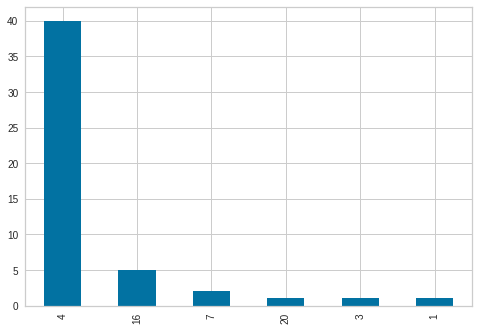

In [ ]:
top_50_best_selling_products_prior.department_id.value_counts().plot(kind='bar');

In [ ]:
data3.head(2)

,user_id,product_list
0,169,"13176,36011,28204,24954,30489,39877,31640,4183..."
1,216,"47766,3800,24184,23233,44987,30169,29252,42117..."


In [ ]:
# Products to recommend for users in matrix1 from top 50 best selling products
def recommendation(matrix,prod_df):
  products_recommended_mat = pd.DataFrame()
  for i in range(1,matrix.shape[0]+1):
    meta_df = pd.DataFrame()
    active_user = matrix[i-1:i,0:1].flatten()
    products_bought_by_sim_users = new_data[new_data['user_id'].isin(matrix[i-1:i,1:].flatten())]['product_id'].unique()
    products_to_recommend = np.intersect1d(products_bought_by_sim_users, prod_df['product_id'])
    product_ids_to_recommend1 = (set(products_to_recommend))-set(new_data[new_data['user_id'].isin(active_user)]['product_id'])
    meta_df = prod_df[prod_df['product_id'].isin(product_ids_to_recommend1)]
    meta_df.insert(loc=0, column='User_id', value=np.repeat(active_user,len(meta_df)))  
    products_recommended_mat = products_recommended_mat.append(meta_df,ignore_index=True).sort_values(['User_id','rank'],ascending=[True,False])
  return products_recommended_mat

In [ ]:
products_recommended_mat1= recommendation(matrix1,top_50_best_selling_products_prior)
products_recommended_mat2= recommendation(matrix2,top_50_best_selling_products_prior)

In [ ]:
products_recommended_mat1

,User_id,product_id,rank,product_name,aisle_id,department_id
0,169,21903,47,Organic Baby Spinach,123,4
1,169,47209,46,Organic Hass Avocado,24,4
2,169,16797,43,Strawberries,24,4
3,169,26209,42,Limes,24,4
4,169,27966,40,Organic Raspberries,123,4
...,...,...,...,...,...,...
49429,206125,5077,9,100% Whole Wheat Bread,112,3
49430,206125,22035,7,Organic Whole String Cheese,21,16
49431,206125,39877,6,Organic Granny Smith Apple,24,4
49432,206125,19660,2,Spring Water,115,7


In [ ]:
products_recommended_mat2

,User_id,product_id,rank,product_name,aisle_id,department_id
0,655,13176,49,Bag of Organic Bananas,24,4
1,655,47209,46,Organic Hass Avocado,24,4
2,655,27966,40,Organic Raspberries,123,4
3,655,49683,35,Cucumber Kirby,83,4
4,655,28204,34,Organic Fuji Apple,24,4
...,...,...,...,...,...,...
59315,206174,26604,10,Organic Blackberries,24,4
59316,206174,22035,7,Organic Whole String Cheese,21,16
59317,206174,39877,6,Organic Granny Smith Apple,24,4
59318,206174,19660,2,Spring Water,115,7


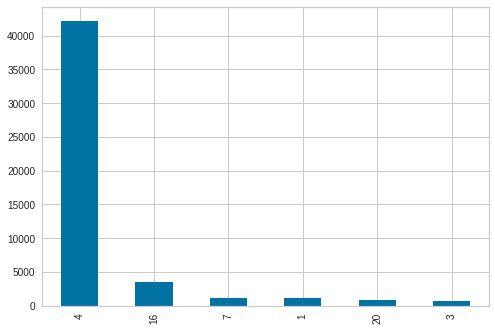

In [ ]:
products_recommended_mat1['department_id'].value_counts().plot(kind='bar')
plt.show()

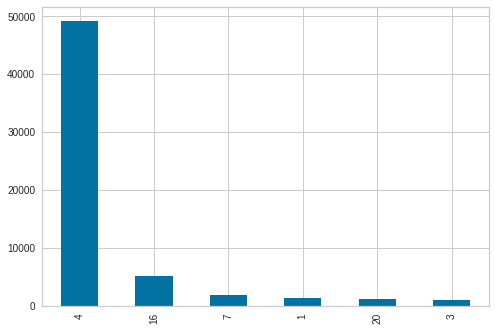

In [ ]:
products_recommended_mat2['department_id'].value_counts().plot(kind='bar')
plt.show()

## Recommendations without clustering 

In [ ]:
tf_idf1.head()

,1,10,100,1000,10001,10004,10005,10006,10008,10009,1001,10010,10011,10014,10015,10016,10017,10022,10023,10025,10027,10029,1003,10031,10032,10033,10034,10035,10036,10037,10038,10039,1004,10040,10041,10043,10044,10047,10048,10049,...,9943,9945,9947,9948,995,9952,9953,9955,9957,996,9961,9963,9964,9966,9967,9968,9969,997,9970,9972,9973,9974,9976,9979,9980,9981,9983,9984,9985,9986,9987,9988,9989,999,9990,9993,9995,9996,9997,Label
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
169,0.0,0.0,0.0,0.0,0.0,0.0,0.132575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
216,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
279,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
352,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
369,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


### Find similar users for whole matrix without clustering

In [ ]:
cos_sim_score = pd.DataFrame(cosine_similarity(tf_idf1,tf_idf1),columns=tf_idf1.index,index=tf_idf1.index)
cos_sim_score.head()

user_id,169,216,279,352,369,383,471,655,713,741,852,860,868,933,984,1019,1023,1064,1107,1120,1164,1212,1261,1299,1313,1454,1495,1523,1537,1538,1553,1559,1589,1607,1683,1707,1737,1754,1772,1795,...,204626,204632,204639,204665,204675,204692,204705,204720,204721,204754,204792,204814,204841,204937,204956,204982,205049,205109,205131,205142,205280,205354,205360,205427,205434,205481,205483,205606,205665,205712,205776,205834,205880,205896,205971,205980,205989,206000,206125,206174
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
169,1.000000,0.050736,0.018427,0.013911,0.000599,0.039779,0.001433,0.044296,0.003278,0.013063,0.015206,0.014160,0.025906,0.017858,0.008150,0.008663,0.000275,0.008771,0.011480,0.008592,0.020903,0.002408,0.013990,0.111620,0.009218,0.021589,0.000000,0.014814,0.017469,0.002582,0.025614,0.060387,0.007777,0.008768,0.014101,0.000418,0.011094,0.009188,0.003679,0.004938,...,0.049108,0.008571,0.019781,0.031650,0.048123,0.003774,0.003524,0.031382,0.025075,0.001059,0.060429,0.025536,0.008133,0.014531,0.007493,0.025082,0.021597,0.002782,0.004073,0.010314,0.008155,0.008586,0.014312,0.011025,0.024711,0.005598,0.042000,0.001134,0.023814,0.033175,0.043237,0.025929,0.001745,0.002230,0.031833,0.007745,0.000760,0.004012,0.019612,0.019679
216,0.050736,1.000000,0.023983,0.005393,0.000360,0.023866,0.018439,0.013100,0.003261,0.006927,0.005470,0.011405,0.045910,0.005169,0.015833,0.019127,0.002618,0.004825,0.021521,0.006647,0.013795,0.009200,0.005439,0.015264,0.010477,0.014248,0.000000,0.019794,0.000000,0.003692,0.041803,0.028342,0.015070,0.006706,0.004284,0.000000,0.013802,0.026738,0.007134,0.008285,...,0.018996,0.002576,0.012243,0.006620,0.003904,0.001452,0.000904,0.011259,0.010866,0.005115,0.025764,0.013925,0.001352,0.011771,0.004699,0.012435,0.014452,0.011409,0.007221,0.014312,0.004606,0.011040,0.015664,0.003969,0.017620,0.002440,0.010871,0.003892,0.022275,0.024960,0.004523,0.004932,0.003792,0.001942,0.034595,0.004270,0.001196,0.001029,0.003260,0.008103
279,0.018427,0.023983,1.000000,0.023785,0.001728,0.019480,0.000000,0.015378,0.026597,0.021769,0.010480,0.003722,0.068559,0.012163,0.016865,0.001669,0.002270,0.007197,0.013773,0.010626,0.066162,0.002946,0.041879,0.009921,0.008062,0.036863,0.000000,0.024255,0.001104,0.000293,0.017801,0.028294,0.006257,0.030268,0.030878,0.001061,0.022497,0.035043,0.000000,0.000701,...,0.011274,0.004843,0.025351,0.029144,0.005516,0.003458,0.074583,0.030040,0.043507,0.002449,0.026390,0.026395,0.007912,0.072659,0.005409,0.001413,0.047143,0.009835,0.005566,0.010484,0.009211,0.075336,0.023757,0.000000,0.020516,0.005060,0.025393,0.009579,0.007613,0.036860,0.006853,0.021074,0.000000,0.015419,0.030613,0.003566,0.011359,0.008457,0.016063,0.009401
352,0.013911,0.005393,0.023785,1.000000,0.011152,0.025390,0.000000,0.015331,0.013086,0.005805,0.006023,0.009044,0.024086,0.000234,0.008163,0.011740,0.001573,0.026199,0.002399,0.001826,0.033792,0.001461,0.057808,0.015655,0.025957,0.021351,0.002414,0.002598,0.013325,0.003187,0.021044,0.014145,0.024782,0.044394,0.029853,0.002758,0.002213,0.029134,0.001966,0.005587,...,0.000000,0.009891,0.050213,0.025483,0.048632,0.002568,0.038959,0.033003,0.037073,0.004041,0.010051,0.021097,0.026294,0.047381,0.022682,0.025696,0.027973,0.006716,0.012240,0.023532,0.010756,0.038415,0.023711,0.000000,0.008526,0.003015,0.032830,0.013309,0.008983,0.073759,0.005387,0.028004,0.000000,0.008782,0.039315,0.000900,0.031693,0.015328,0.032347,0.030610
369,0.000599,0.000360,0.001728,0.011152,1.000000,0.000000,0.004362,0.006022,0.000370,0.001659,0.003533,0.000325,0.003828,0.002285,0.002659,0.003532,0.001782,0.000445,0.000000,0.002857,0.013123,0.000000,0.000479,0.001389,0.016825,0.016436,0.000000,0.000000,0.035901,0.011899,0.004605,0.001042,0.005385,0.051848,0.003351,0.153180,0.002061,0.001255,0.015549,0.040232,...,0.001604,0.000162,0.001289,0.000734,0.000182,0.000678,0.016238,0.004025,0.018222,0.000649,0.024719,0.008855,0.011747,0.000000,0.001119,0.007502,0.000000,0

In [ ]:
matrix = cos_sim_score.apply(lambda s, n: pd.Series(s.nlargest(n).index), n=5).to_numpy().transpose()
matrix

array([[   169,  67645,  68631,   1299,  46716],
       [   216,  44759, 167527, 203571,  72798],
       [   279,  92767,  30131,  74201,  43108],
       ...,
       [206000,  56132, 200653,  40850,  75503],
       [206125,  27538, 107700,  55189,  44483],
       [206174, 120185,  32222, 143942, 125872]])

In [ ]:
cos_sim_score[169].sort_values(ascending=False)

user_id
169       1.000000
67645     0.130503
68631     0.116909
1299      0.111620
46716     0.104414
            ...   
116334    0.000000
80946     0.000000
80798     0.000000
117228    0.000000
66438     0.000000
Name: 169, Length: 5000, dtype: float64

In [ ]:
products_recommended_mat1_noc = recommendation(matrix,top_50_best_selling_products_prior)

In [ ]:
products_recommended_mat1_noc

,User_id,product_id,rank,product_name,aisle_id,department_id
0,169,21903,47,Organic Baby Spinach,123,4
1,169,47209,46,Organic Hass Avocado,24,4
2,169,16797,43,Strawberries,24,4
3,169,26209,42,Limes,24,4
4,169,27966,40,Organic Raspberries,123,4
...,...,...,...,...,...,...
111063,206174,26604,10,Organic Blackberries,24,4
111064,206174,22035,7,Organic Whole String Cheese,21,16
111065,206174,39877,6,Organic Granny Smith Apple,24,4
111066,206174,19660,2,Spring Water,115,7


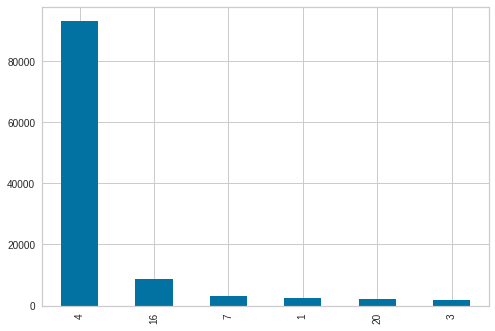

In [ ]:
products_recommended_mat1_noc['department_id'].value_counts().plot(kind='bar')
plt.show()

## Evaluation of the model
- products_recommended_mat1(top 50 best selling product - cluster 1)
- products_recommended_mat2(top 50 best selling product - cluster2)
- products_recommended_mat1_noc(top 50 best selling - no cluster)


In [ ]:
order_products_train

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
...,...,...,...,...
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1


In [ ]:
product1 = products.drop('product_name',axis=1)
order_products_train1 = order_products_train.drop('reordered',axis=1)
products_merge = order_products_train1.merge(product1,on='product_id')
test = orders.merge(products_merge,on='order_id')

In [ ]:
test.shape

(1384617, 11)

In [ ]:
test_data = test[test.user_id.isin(users_5000)]
test_data = test_data.rename(columns={"user_id": "User_id"})
test_data

,order_id,User_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,aisle_id,department_id
1137,767489,169,train,7,2,12,30.0,21616,10,123,4
1138,767489,169,train,7,2,12,30.0,21903,11,123,4
1139,767489,169,train,7,2,12,30.0,24184,3,83,4
1140,767489,169,train,7,2,12,30.0,32689,1,123,4
1141,767489,169,train,7,2,12,30.0,3952,8,83,4
...,...,...,...,...,...,...,...,...,...,...,...
1384377,1620607,206174,train,53,4,22,10.0,15016,13,100,21
1384378,1620607,206174,train,53,4,22,10.0,30440,10,93,3
1384379,1620607,206174,train,53,4,22,10.0,23926,1,31,7
1384380,1620607,206174,train,53,4,22,10.0,13512,6,96,20


In [ ]:
top_5_ranks_mat1 = products_recommended_mat1.groupby(['User_id'])['rank'].nlargest(5).droplevel(level=0).index
top_5_ranks_mat2 = products_recommended_mat2.groupby(['User_id'])['rank'].nlargest(5).droplevel(level=0).index
top_5_ranks_mat_noc = products_recommended_mat1_noc.groupby(['User_id'])['rank'].nlargest(5).droplevel(level=0).index

In [ ]:
products_recommended_mat1 = products_recommended_mat1.iloc[top_5_ranks_mat1]
products_recommended_mat2 = products_recommended_mat2.iloc[top_5_ranks_mat2]
products_recommended_mat1_noc = products_recommended_mat1_noc.iloc[top_5_ranks_mat_noc]

In [ ]:
test_data_for_cluster1 = test_data[test_data.User_id.isin(products_recommended_mat1.User_id.unique())]
test_data_for_cluster2 = test_data[test_data.User_id.isin(products_recommended_mat2.User_id.unique())]

In [ ]:
products_recommended_mat1.User_id.nunique(),products_recommended_mat2.User_id.nunique(),products_recommended_mat1_noc.User_id.nunique()

(2404, 2596, 5000)

In [ ]:
products_recommended_mat1 = products_recommended_mat1[products_recommended_mat1.User_id.isin(test_data.User_id.unique())]
products_recommended_mat2 = products_recommended_mat2[products_recommended_mat2.User_id.isin(test_data.User_id.unique())]
products_recommended_mat1_noc = products_recommended_mat1_noc[products_recommended_mat1_noc.User_id.isin(test_data.User_id.unique())]

In [ ]:
products_recommended_mat1.User_id.nunique(),products_recommended_mat2.User_id.nunique(),products_recommended_mat1_noc.User_id.nunique()

(1537, 1650, 3187)

In [ ]:
test_data_for_cluster1.User_id.nunique(),test_data_for_cluster2.User_id.nunique(),test_data.User_id.nunique()

(1537, 1650, 3187)

In [ ]:
test_data.product_id.nunique(),products_recommended_mat1_noc.product_id.nunique()

(10938, 47)

In [ ]:
test_data_for_cluster1.product_id.nunique(),products_recommended_mat1.product_id.nunique()

(7898, 45)

In [ ]:
test_data_for_cluster2.product_id.nunique(),products_recommended_mat2.product_id.nunique()

(6892, 43)

In [ ]:
products_recommended_mat1

,User_id,product_id,rank,product_name,aisle_id,department_id
0,169,21903,47,Organic Baby Spinach,123,4
1,169,47209,46,Organic Hass Avocado,24,4
2,169,16797,43,Strawberries,24,4
3,169,26209,42,Limes,24,4
4,169,27966,40,Organic Raspberries,123,4
...,...,...,...,...,...,...
49402,206125,24852,50,Banana,24,4
49403,206125,21137,48,Organic Strawberries,24,4
49404,206125,21903,47,Organic Baby Spinach,123,4
49405,206125,47766,45,Organic Avocado,24,4


In [ ]:
d1 = products_recommended_mat1[['User_id','product_id']].append(test_data[['User_id','product_id']],ignore_index=True)
intersection_mat1 = d1[d1.duplicated()]
intersection_mat1

,User_id,product_id
7660,169,21903
8004,2285,26209
8099,2652,47626
8101,2652,26209
8168,2986,47626
...,...,...
50357,204721,21137
50358,204721,24852
50409,204841,47626
50410,204841,21903


In [ ]:
products_recommended_mat2

,User_id,product_id,rank,product_name,aisle_id,department_id
0,655,13176,49,Bag of Organic Bananas,24,4
1,655,47209,46,Organic Hass Avocado,24,4
2,655,27966,40,Organic Raspberries,123,4
3,655,49683,35,Cucumber Kirby,83,4
4,655,28204,34,Organic Fuji Apple,24,4
...,...,...,...,...,...,...
59296,206174,24852,50,Banana,24,4
59297,206174,47209,46,Organic Hass Avocado,24,4
59298,206174,47766,45,Organic Avocado,24,4
59299,206174,47626,44,Large Lemon,24,4


In [ ]:
d1 = products_recommended_mat2[['User_id','product_id']].append(test_data[['User_id','product_id']],ignore_index=True)
intersection_mat2 = d1[d1.duplicated()]
intersection_mat2

,User_id,product_id
8526,1990,37646
9183,5402,21137
9327,6052,24852
9595,8224,21137
9599,8224,21903
...,...,...
48312,192329,47209
48356,192481,47626
48999,196222,16797
49080,196516,26209


In [ ]:
products_recommended_mat1_noc

,User_id,product_id,rank,product_name,aisle_id,department_id
0,169,21903,47,Organic Baby Spinach,123,4
1,169,47209,46,Organic Hass Avocado,24,4
2,169,16797,43,Strawberries,24,4
3,169,26209,42,Limes,24,4
4,169,27966,40,Organic Raspberries,123,4
...,...,...,...,...,...,...
111044,206174,24852,50,Banana,24,4
111045,206174,47209,46,Organic Hass Avocado,24,4
111046,206174,47766,45,Organic Avocado,24,4
111047,206174,47626,44,Large Lemon,24,4


In [ ]:
d1 = products_recommended_mat1_noc[['User_id','product_id']].append(test_data[['User_id','product_id']],ignore_index=True)
intersection_mat_noc = d1[d1.duplicated()]
intersection_mat_noc

,User_id,product_id
15910,169,21903
16005,1019,24852
16192,1990,37646
16349,2652,47626
16351,2652,26209
...,...,...
58581,204720,47626
58607,204721,21137
58608,204721,24852
58659,204841,47626


In [ ]:
results = pd.DataFrame()
new_df= pd.DataFrame()
def eval(no_of_recom_prods_bought,no_of_prod_recommended,no_of_prods_test_data,no_users_boughts_recomm,no_users_recom_prod,index):
  precision = round((no_of_recom_prods_bought/no_of_prod_recommended)*100,2)
  recall = round((no_of_recom_prods_bought/no_of_prods_test_data)*100,2)
  f1_score = round((2*((precision*recall)/(precision+recall))),2)
  percent_users = round((no_users_boughts_recomm/no_users_recom_prod)*100,2)
  print('Precision : ', precision) 
  print('Recall : ', recall)
  print('f1-score : ', f1_score)
  print('Number of users bought recommended products : ', no_users_boughts_recomm)
  print('Total number of users : ', no_users_recom_prod)
  print('Percentage of users who bought from recommendations : ', percent_users)
  new_df = pd.DataFrame({'Precision': precision, 'Recall': recall, 'F1_score': f1_score, 'No of users bought': no_users_boughts_recomm, 
                'Total no of users': no_users_recom_prod, '% of users bought recommendations': percent_users},index=[index])
  return new_df

In [ ]:
print('Evaluation of recommendation of products for cluster 1 users\n')
r1 = eval(intersection_mat1.shape[0],products_recommended_mat1.shape[0],test_data_for_cluster1.shape[0],intersection_mat1.User_id.nunique(),products_recommended_mat1.User_id.nunique(),'cluster1')
r1

Evaluation of recommendation of products for cluster 1 users

Precision :  3.09
Recall :  1.01
f1-score :  1.52
Number of users bought recommended products :  212
Total number of users :  1537
Percentage of users who bought from recommendations :  13.79


,Precision,Recall,F1_score,No of users bought,Total no of users,% of users bought recommendations
cluster1,3.09,1.01,1.52,212,1537,13.79


In [ ]:
print('Evaluation of recommendation of products for cluster 2 users\n')
r2 = eval(intersection_mat2.shape[0],products_recommended_mat2.shape[0],test_data_for_cluster2.shape[0],intersection_mat2.User_id.nunique(),products_recommended_mat2.User_id.nunique(),'cluster 2')
r2 

Evaluation of recommendation of products for cluster 2 users

Precision :  1.2
Recall :  0.51
f1-score :  0.72
Number of users bought recommended products :  93
Total number of users :  1650
Percentage of users who bought from recommendations :  5.64


,Precision,Recall,F1_score,No of users bought,Total no of users,% of users bought recommendations
cluster 2,1.2,0.51,0.72,93,1650,5.64


In [ ]:
print('Evaluation of recommendation of products for all users without clustering\n')
r3 = eval(intersection_mat_noc.shape[0],products_recommended_mat1_noc.shape[0],test_data.shape[0],intersection_mat_noc.User_id.nunique(),products_recommended_mat1_noc.User_id.nunique(),'No Cluster')
r3

Evaluation of recommendation of products for all users without clustering

Precision :  2.12
Recall :  0.78
f1-score :  1.14
Number of users bought recommended products :  303
Total number of users :  3187
Percentage of users who bought from recommendations :  9.51


,Precision,Recall,F1_score,No of users bought,Total no of users,% of users bought recommendations
No Cluster,2.12,0.78,1.14,303,3187,9.51


In [ ]:
(3.09+1.20)/2,(1.01+0.51)/2,(1.52+0.72)/2,212+93,round((305/3187)*100,2)

(2.145, 0.76, 1.12, 305, 9.57)

In [ ]:
r4 = pd.DataFrame({'Precision': 2.145, 'Recall': 0.76, 'F1_score': 1.12, 'No of users bought': 305, 
                'Total no of users': 3187, '% of users bought recommendations': 9.57},index=['combined score of clusters(avg/sum)'])

In [ ]:
results = r1.append([r2,r3,r4])
results

,Precision,Recall,F1_score,No of users bought,Total no of users,% of users bought recommendations
cluster1,3.090,1.01,1.52,212,1537,13.79
cluster 2,1.200,0.51,0.72,93,1650,5.64
No Cluster,2.120,0.78,1.14,303,3187,9.51
combined score of clusters(avg/sum),2.145,0.76,1.12,305,3187,9.57


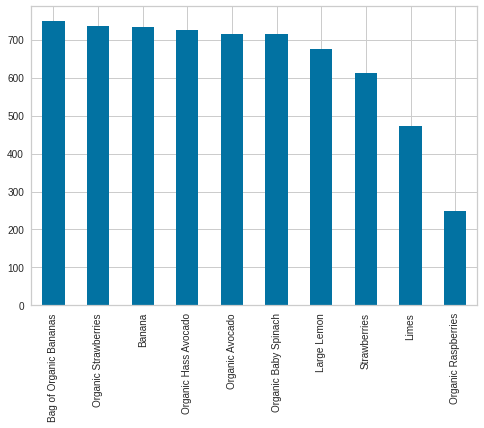

In [ ]:
products_recommended_mat1.product_name.value_counts().head(10).plot(kind='bar');

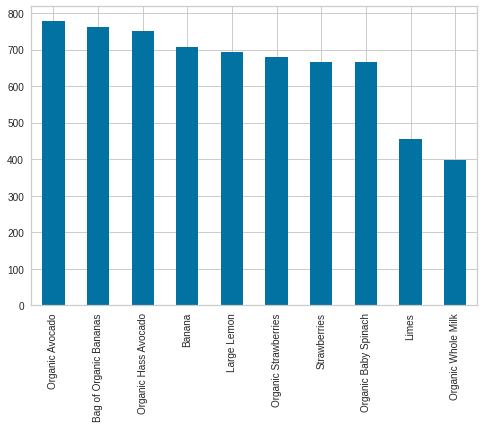

In [ ]:
products_recommended_mat2.product_name.value_counts().head(10).plot(kind='bar');

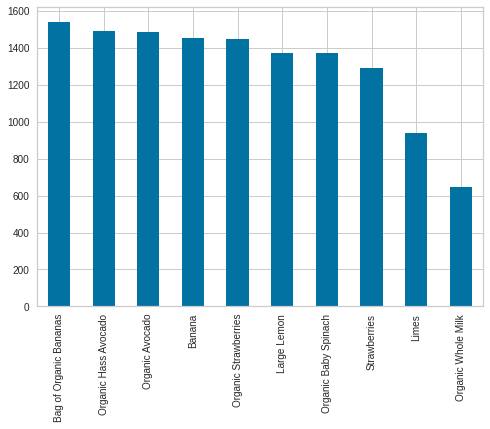

In [ ]:
products_recommended_mat1_noc.product_name.value_counts().head(10).plot(kind='bar');